# Image Caption BLIP-2: A new Visual Language Model # 

BLIP-2 is a new visual language model (VLM) capable of multimodal tasks like captioning, visual dialogue and visual question answering.

* BLIP-2 stands for Bootstrapping Language-Image Pre-training with frozen unimodal models.

* In previous approaches we used pre-trained unimodal models for Vision-language pre-training (VLP). This requires aligning visual and textual features, which can be challenging. This is particularly true for frozen unimodal models (like LLMs), which have not seen any images during their pre-training. BLIP address this problem, by introducing a lightweight module called Querying Transformer (Q-Former) that effectively enhances the vision-language model.

* Q-Former is a lightweight transformer that uses learnable query vectors to extract visual features from the frozen image encoder. It acts as an information bottleneck between the frozen image encoder and the frozen LLM, where it feeds the most useful visual feature for the LLM to output the desired text. 

* Key ideas of BLIP-2:

![Merge Architecture for Encoder-Decoder Model](..\images\BLIP-2.png)

In [ ]:
#https://ug.linkedin.com/posts/younes-belkada-b1a903145_fine-tune-large-image-captioning-models-using-activity-7052288723215908865-AKtg

## Load the image captioning dataset

Let's load the image captioning dataset.

In [1]:
import src.utils as plh

base_path = plh.get_project_root()

In [ ]:
#Pandas
from pandas import read_parquet

#HuggingFace: Dataset Library
from datasets import Dataset
from datasets import Image

#General Library
import os
import gc

def get_dataset(filetype, **kargs):
    
    """
    Create dataset based on file
    """
    
    filepath = ""
    data_sample = -1
    
    #Read data
    if filetype == 'train':

        filepath = kargs["train_filepath"]
        data_sample = kargs["train_sample"]

    elif filetype == 'valid':

        filepath = kargs["valid_filepath"]
        data_sample = kargs["valid_sample"]
    
    elif filetype == 'test':
        
        filepath = kargs["test_filepath"]
        data_sample = kargs["test_sample"]
        
    if len(filepath) == 0:
        return

    seed = kargs["seed"]
    image_base_path = kargs["image_base_path"]
   
    #print(f'Reading file from path: "{filepath}"')
    db_set = read_parquet(filepath)
    
    if data_sample != -1:
        db_set = db_set.sample(n = data_sample, random_state = seed)

    image_paths = list(image_base_path + '/' + db_set["image_name"])
    captions = list(db_set["caption"])
    
    del [db_set]
    
    db_set = Dataset.from_dict(
                                {
                                    "image": image_paths,
                                    "text": captions,
                                }
                            ).cast_column("image", Image())

    del [image_paths, captions]
    gc.collect() 
    
    return db_set

In [ ]:
train_dbset = get_dataset(filetype = 'train', 
                          seed = 44, 
                          train_filepath = os.path.join(base_path, 'data', 'processed', 'train_data_processed.parquet'),
                          train_sample = 10000, 
                          image_base_path = os.path.join(base_path, 'data', 'images'),
                         )

In [ ]:
valid_dbset = get_dataset(filetype = 'valid', 
                          seed = 44, 
                          valid_filepath = os.path.join(base_path, 'data', 'processed', 'validate_data_processed.parquet'),
                          valid_sample = 1000, 
                          image_base_path = os.path.join(base_path, 'data', 'images'),
                         )

In [ ]:
test_dbset = get_dataset(filetype = 'test', 
                          seed = 44, 
                          test_filepath = os.path.join(base_path, 'data', 'processed', 'test_data_processed.parquet'),
                          test_sample = -1, 
                          image_base_path = os.path.join(base_path, 'data', 'images'),
                         )

Let's retrieve the caption of the first example:

In [ ]:
train_dbset[0]["text"]

And the corresponding image

In [ ]:
train_dbset[0]["image"].resize((252,252))

## Create PyTorch Dataset

Let's define below the dataset as well as the data collator!

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    
    def __init__(self, dataset, processor):
        
        self.dataset = dataset
        self.processor = processor
        #self.new_size = (256,256)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        
        item = self.dataset[idx]
        encoding = self.processor(images = item["image"],#.resize(self.new_size), 
                                  #padding = "max_length", 
                                  return_tensors = "pt"
                                 )
        
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        
        return encoding

def collate_fn(batch):
    
    # pad the input_ids and attention_mask
    processed_batch = {}
    
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                                            [example["text"] for example in batch], 
                                            padding = "max_length" ,#True, 
                                            max_length = 10, #9, #16
                                            return_tensors = "pt",
                                            truncation = True,
                                            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch


## Load processor ##

In [ ]:
from transformers import Blip2Processor

checkpoint = 'Salesforce/blip2-opt-2.7b'
processor = Blip2Processor.from_pretrained(checkpoint)

Now that we have loaded the processor, let's load the dataset and the dataloader:

In [ ]:
BATCH_SIZE = 32 #38 #32(Worked) #16(Worked) #56 #64 #128 #512 #1024

In [ ]:
train_dataloader = DataLoader(ImageCaptioningDataset(train_dbset, processor), 
                              shuffle = True, 
                              batch_size = BATCH_SIZE, 
                              collate_fn = collate_fn,
                              num_workers  = 2,
                              prefetch_factor  = 2,
                             )

del train_dbset

In [ ]:
valid_dataloader = DataLoader(ImageCaptioningDataset(valid_dbset, processor), 
                              batch_size = BATCH_SIZE, 
                              collate_fn = collate_fn,
                              num_workers  = 2,
                              prefetch_factor = 2,
                             )

del valid_dbset

In [ ]:
test_dataloader = DataLoader(ImageCaptioningDataset(test_dbset , processor), 
                              batch_size = BATCH_SIZE, 
                              collate_fn = collate_fn,
                              num_workers  = 2,
                              prefetch_factor = 2,
                             )

del test_dbset

In [ ]:
gc.collect()

# Train model #

## Load model and processor

* Original model "Salesforce/blip2-opt-2.7b" was too large(15.5GB) to fit in the RAM. Even after sucessfully loading model, was not able to train and gave resource issue.
* Used model_id "ybelkada/blip2-opt-2.7b-fp16-sharded" which has weights with Float16 precision(FP16) and model is sharded with each size of 995 MB.

In [ ]:
from transformers import Blip2ForConditionalGeneration
import torch

device_map = {
    "query_tokens": 0,
    "vision_model":0,
    "language_model": 1,
    "language_projection": 1,
    "lm_head": 1,
    "qformer": 0,
}
max_memory = {i: "4GB" for i in range(2)} #2 GPU 

model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", 
                                                      device_map = device_map,  #"auto", # "balanced_low_0"
                                                      max_memory = max_memory,
                                                      load_in_8bit = True,
                                                      torch_dtype = torch.float16,
                                                     )

#model

Next we define our `LoraConfig` object. We explicitly tell 

In [ ]:
from peft import LoraConfig, get_peft_model   
    
# Let's define the LoraConfig
config = LoraConfig(
    r = 16, #32, #10, #18, #16, # Lower rank results in fewer trainable parameters.
    lora_alpha = 32,
    lora_dropout = 0.05,
    bias = "none",
    target_modules = ["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
    
model.print_trainable_parameters()

In [ ]:
#from peft import PeftModel

#peft_model_id = '/kaggle/input/pre-trained-peft-mode'

#If pre-train peft adapater exits load that
#if os.path.exists(peft_model_id):    
#    model = PeftModel.from_pretrained(model, peft_model_id)

## Train the model ##

Let's train the model! Run the simply the cell below for training the model

In [ ]:
from accelerate import Accelerator
#import torch

lr = 6e-4 #2e-4 #5e-4 #8e-4
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
#model.gradient_checkpointing_enable()

accelerator = Accelerator()
model, optimizer, train_dataloader, valid_dataloader  = accelerator.prepare(model, optimizer, train_dataloader, valid_dataloader)

In [ ]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = accelerator.device
print(f'Device: {device}')

In [ ]:
#Eval metric Library
from rouge_score import rouge_scorer, scoring
from evaluate import load

rouge_types = ["rouge1", "rouge2", "rougeL"]
use_stemmer = False
rouge_score_obj = rouge_scorer.RougeScorer(rouge_types = rouge_types, use_stemmer = use_stemmer)
bleu_score_obj = load("bleu")

def compute_metrics(pred_text, labels_text):

    for ref, pred in zip(labels_text, pred_text):

        #ROUGE Score
        output_score = rouge_score_obj.score(prediction = pred.strip(), target = ref.strip())
        rouge_score_aggregator.add_scores(output_score)
        
        #BLEU Score
        bleu_score = {}

        results = bleu_score_obj.compute(predictions = pred_text, references = labels_text, max_order  = 2)
        bleu_score['bleu@2'] = results['bleu']

        results = bleu_score_obj.compute(predictions = pred_text, references = labels_text, max_order  = 1)
        bleu_score['bleu@1'] = results['bleu']

        bleu_score_aggregator.add_scores(bleu_score)

        
    agg_bleu = bleu_score_aggregator.aggregate()
    agg_rouge = rouge_score_aggregator.aggregate()

    return {
        #ROUGE metric
        "rouge1_fmeasure": round(agg_rouge['rouge1'].mid.fmeasure, 2),
        "rouge2_fmeasure": round(agg_rouge['rouge2'].mid.fmeasure, 2),
        "rougeL_fmeasure": round(agg_rouge['rougeL'].mid.fmeasure, 2),
        
        #BLEU metric
        "bleu@1": round(agg_bleu['bleu@1'].mid, 2),
        "bleu@2": round(agg_bleu['bleu@2'].mid, 2),
    }

In [ ]:
from tqdm import tqdm

epoch = 10
gradient_accumulation_steps = 2 #8 #4

#model = model.to(device)
for epoch in range(epoch):
    
    print("Epoch:", epoch)
    
    model.train()
    idx = 0
    for batch in tqdm(train_dataloader):
    
        input_ids = batch.pop("input_ids")#.to(device)
        pixel_values = batch.pop("pixel_values").to(torch.float16)#.to(device, torch.float16)

        outputs = model(input_ids = input_ids,
                        pixel_values = pixel_values,
                        labels = input_ids)

        loss = outputs.loss
        loss = loss / gradient_accumulation_steps
        
        #loss.backward()
        accelerator.backward(loss)

        if (idx + 1) % gradient_accumulation_steps == 0:
            
            print(f"Step: {idx+1}, Loss: {outputs.loss.item()}")  #loss

            optimizer.step()
            optimizer.zero_grad()
        
        idx = idx + 1
            
    model.eval()
    
    rouge_score_aggregator = scoring.BootstrapAggregator()
    bleu_score_aggregator = scoring.BootstrapAggregator()

    for batch in tqdm(valid_dataloader):

        input_ids = batch.pop("input_ids")#.to(device)
        pixel_values = batch.pop("pixel_values").to(torch.float16)
    
        predictions = model.generate(pixel_values, max_length = 10)#9 #16
        predictions = processor.batch_decode(predictions, skip_special_tokens = True)
        labels = processor.batch_decode(input_ids, skip_special_tokens = True)

        eval_metric = compute_metrics(predictions, labels) 
    
    print(f"Epoch {epoch}: Eval metric on valid dbset:", eval_metric)

In [ ]:
gc.collect()

In [ ]:
#Save Peft Model
model.save_pretrained(os.join.path(base_path, 'data', 'blip2_visual_peft'))

**Training results with different configurations:**

<table>
<tr>
    <th>Trail</th><th>max_lenght</th><th>batch_size</th><th>LoRA rank</th> <th>lr</th> <th>gradient_accumulation_steps</th> <th>epoch</th> <th>rouge1</th> <th>rouge2</th> <th>rougel</th><th>bleu@1</th>  <th>bleu@2</th>
</tr>
   
    

<tr>
<th>1</th><th>16</th><th>32</th><th>16</th><th>5e-4</th><th>1</th><th>0</th><th>0.43</th><th>0.12</th><th> 0.43</th><th></th><th></th><th></th><th></th>    
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>1</th><th>0.45</th><th>0.15</th><th>0.44</th><th></th><th></th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>2</th><th>0.45</th><th>0.14</th><th>0.45</th><th></th><th></th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>3</th><th>0.46</th><th>0.15</th><th>0.45</th><th></th><th></th>
</tr>    
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>4</th><th>0.46</th><th>0.15</th><th>0.45</th><th></th><th></th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>5</th><th>0.45</th><th>0.15</th><th>0.45</th><th></th><th></th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>6</th><th>0.45</th><th>0.15</th><th>0.45</th><th></th><th></th>
</tr>

    
<tr>
<th>2</th><th>16</th><th>32</th><th>18</th><th>5e-4</th><th>1</th><th>0</th><th>0.43</th><th>0.13</th><th>0.43</th><th></th><th></th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>1</th><th>0.44</th><th>0.14</th><th>0.44</th><th></th><th></th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>2</th><th>0.45</th><th>0.14</th><th>0.45</th><th></th><th></th>
</tr>    
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>3</th><th>0.45</th><th>0.14</th><th>0.44</th><th></th><th></th>
</tr>
    
    
<tr>
<th>3</th><th>16</th><th>32</th><th>10</th><th>5e-4</th><th>1</th><th>0</th><th>0.44</th><th>0.13</th><th>0.43</th><th></th><th></th>
</tr>    
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>1</th><th>0.45</th><th>0.14</th><th>0.44</th><th></th><th></th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>2</th><th>0.45</th><th>0.14</th><th>0.45</th><th></th><th></th>
</tr>    
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>3</th><th>0.45</th><th>0.14</th><th>0.45</th><th></th><th></th>
</tr>
   
    
<tr>
<th>4</th><th>16</th><th>32</th><th>16</th><th>2e-4</th><th>8</th><th>0</th><th>0.37</th><th>0.08</th><th>0.36</th><th>0.29</th><th>0.14</th>
</tr> 
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>1</th><th>0.39</th><th>0.09</th><th>0.39</th><th>0.33</th><th>0.16</th>
</tr>    
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>2</th><th>0.41</th><th>0.11</th><th>0.41</th><th>0.35</th><th>0.18</th>
</tr>    
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>3</th><th>0.42</th><th>0.11</th><th>0.42</th><th>0.37</th><th>0.19</th>
</tr>    
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>4</th><th>0.43</th><th>0.11</th><th>0.43</th><th>0.37</th><th>0.2</th>
</tr>
    
    
<tr>
<th>5</th><th>16</th><th>32</th><th>32</th><th>5e-4</th><th>8</th><th>0</th><th>0.37</th><th>0.08</th><th>0.37</th><th>0.31</th><th>0.14</th>
</tr>    
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>1</th><th>0.4</th><th>0.1</th><th>0.39</th><th>0.35</th><th>0.18</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>2</th><th>0.42</th><th>0.11</th><th>0.41</th><th>0.38</th><th>0.2</th>
</tr>   
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>3</th><th>0.41</th><th>0.11</th><th>0.41</th><th>0.38</th><th>0.21</th>
</tr>       
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>4</th><th>0.43</th><th>0.13</th><th>0.42</th><th>0.39</th><th>0.22</th>
</tr> 
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>5</th><th>0.43</th><th>0.13</th><th>0.43</th><th>0.39</th><th>0.22</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>6</th><th>0.43</th><th>0.13</th><th>0.42</th><th>0.39</th><th>0.22</th>
</tr>
 <tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>7</th><th>0.43</th><th>0.13</th><th>0.43</th><th>0.4</th><th>0.23</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>8</th><th>0.43</th><th>0.13</th><th>0.43</th><th>0.4</th><th>0.23</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>9</th><th>0.43</th><th>0.13</th><th>0.42</th><th>0.41</th><th>0.23</th>
</tr>
    
    
<tr>
<th>6</th><th>16</th><th>32</th><th>16</th><th>5e-4</th><th>8</th><th>0</th><th>0.38</th><th>0.08</th><th>0.37</th><th>0.32</th><th>0.15</th>
</tr>

    
<tr>
<th>7</th><th>16</th><th>38</th><th>16</th><th>5e-4</th><th>4</th><th>0</th><th>0.36</th><th>0.09</th><th>0.36</th><th>0.33</th><th>0.16</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>1</th><th>0.38</th><th>0.1</th><th>0.37</th><th>0.36</th><th>0.19</th>
</tr>
    
    
<tr>
<th>8</th><th>9</th><th>38</th><th>16</th><th>8e-4</th><th>4</th><th>0</th><th>0.37</th><th>0.1</th><th>0.37</th><th>0.35</th><th>0.18</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>1</th><th>0.38</th><th>0.1</th><th>0.38</th><th>0.36</th><th>0.19</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>2</th><th>0.38</th><th>0.11</th><th>0.38</th><th>0.37</th><th>0.2</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>3</th><th>0.39</th><th>0.11</th><th>0.38</th><th>0.37</th><th>0.2</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>4</th><th>0.39</th><th>0.11</th><th>0.39</th><th>0.37</th><th>0.2</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>5</th><th>0.38</th><th>0.11</th><th>0.38</th><th>0.37</th><th>0.2</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>6</th><th>0.38</th><th>0.11</th><th>0.38</th><th>0.37</th><th>0.2</th>
</tr>
    
<tr>
<th>9</th><th>9</th><th>32</th><th>16</th><th>5e-4</th><th>1</th><th>0</th><th>0.38</th><th>0.1</th><th>0.38</th><th>0.36</th><th>0.19</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>1</th><th>0.39</th><th>0.11</th><th>0.38</th><th>0.36</th><th>0.2</th>
</tr>    

<tr>
<th>10</th><th>10</th><th>32</th><th>16</th><th>6e-4</th><th>2</th><th>0</th><th>0.40</th><th>0.11</th><th>0.40</th><th>0.38</th><th>0.20</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>1</th><th>0.41</th><th>0.12</th><th>0.41</th><th>0.38</th><th>0.21</th>
</tr>  
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>2</th><th>0.42</th><th>0.12</th><th>0.41</th><th>0.38</th><th>0.21</th>
</tr>  
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>3</th><th>0.41</th><th>0.13</th><th>0.41</th><th>0.38</th><th>0.22</th>
</tr>  
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>4</th><th>0.41</th><th>0.12</th><th>0.41</th><th>0.38</th><th>0.21</th>
</tr> 
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>5</th><th>0.41</th><th>0.12</th><th>0.41</th><th>0.39</th><th>0.21</th>
</tr> 
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>6</th><th>0.41</th><th>0.12</th><th>0.41</th><th>0.39</th><th>0.22</th>
</tr> 
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>7</th><th>0.41</th><th>0.12</th><th>0.41</th><th>0.39</th><th>0.22</th>
</tr>
    
    
</table>

Original paper used metric: CIDEr, SPIDER ,BLEU@4 

# Evaluate #

### Train ###

In [ ]:
from transformers import Blip2ForConditionalGeneration
from peft import PeftModel, PeftConfig
from tqdm import tqdm
import torch

peft_model_id = "/kaggle/input/pre-trained-peft-mode"
config = PeftConfig.from_pretrained(peft_model_id)

device = "cuda" if torch.cuda.is_available() else "cpu"
device_map = {
    "query_tokens": 0,
    "vision_model":0,
    "language_model": 1,
    "language_projection": 1,
    "lm_head": 1,
    "qformer": 0,
}
max_memory = {i: "4GB" for i in range(2)} #2 GPU 

model = Blip2ForConditionalGeneration.from_pretrained(config.base_model_name_or_path, 
                                                      device_map = device_map,  #"auto", # "balanced_low_0"
                                                      max_memory = max_memory,
                                                      load_in_8bit = True,
                                                      torch_dtype = torch.float16,
                                                     )


model = PeftModel.from_pretrained(model, peft_model_id)
#model = model.to(device)
#model.eval()

In [ ]:
#Training

rouge_score_aggregator = scoring.BootstrapAggregator()
bleu_score_aggregator = scoring.BootstrapAggregator()

for batch in tqdm(train_dataloader):

    input_ids = batch.pop("input_ids")#.to(device)
    pixel_values = batch.pop("pixel_values").to(torch.float16)#.to(device)

    predictions = model.generate(pixel_values, max_length = 10)#9 #16
    predictions = processor.batch_decode(predictions, skip_special_tokens = True)
    labels = processor.batch_decode(input_ids, skip_special_tokens = True)

    #print(f'Label: {labels}')
    #print(f'Predictions: {predictions}')
    
    eval_metric = compute_metrics(predictions, labels) 

print(f"Metric on train dbset:", eval_metric)
#Metric on train dbset: {'rouge1_fmeasure': 0.45, 'rouge2_fmeasure': 0.16, 'rougeL_fmeasure': 0.44, 'bleu@1': 0.42, 'bleu@2': 0.26}

In [ ]:
#Valid

rouge_score_aggregator = scoring.BootstrapAggregator()
bleu_score_aggregator = scoring.BootstrapAggregator()

for batch in tqdm(valid_dataloader):

    input_ids = batch.pop("input_ids")#.to(device)
    pixel_values = batch.pop("pixel_values").to(torch.float16)#.to(device)

    predictions = model.generate(pixel_values, max_length = 10)#9 #16
    predictions = processor.batch_decode(predictions, skip_special_tokens = True)
    labels = processor.batch_decode(input_ids, skip_special_tokens = True)

    #print(f'Label: {labels}')
    #print(f'Predictions: {predictions}')
    
    eval_metric = compute_metrics(predictions, labels) 
    
print(f"Metric on valid dbset:", eval_metric)
#Metric on valid dbset: {'rouge1_fmeasure': 0.42, 'rouge2_fmeasure': 0.13, 'rougeL_fmeasure': 0.41, 'bleu@1': 0.39, 'bleu@2': 0.22}

In [ ]:
#test

rouge_score_aggregator = scoring.BootstrapAggregator()
bleu_score_aggregator = scoring.BootstrapAggregator()

for batch in tqdm(test_dataloader):

    input_ids = batch.pop("input_ids")#.to(device)
    pixel_values = batch.pop("pixel_values").to(torch.float16)#.to(device)

    predictions = model.generate(pixel_values, max_length = 10)#9 #16
    predictions = processor.batch_decode(predictions, skip_special_tokens = True)
    labels = processor.batch_decode(input_ids, skip_special_tokens = True)

    #print(f'Label: {labels}')
    #print(f'Predictions: {predictions}')
    
    eval_metric = compute_metrics(predictions, labels) 

print(f"Metric on test dbset:", eval_metric)
#Metric on test dbset: {'rouge1_fmeasure': 0.45, 'rouge2_fmeasure': 0.13, 'rougeL_fmeasure': 0.45, 'bleu@1': 0.41, 'bleu@2': 0.23}

# Inferance #

In [3]:
from transformers import Blip2Processor

checkpoint = 'Salesforce/blip2-opt-2.7b'
processor = Blip2Processor.from_pretrained(checkpoint)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [5]:
from transformers import Blip2ForConditionalGeneration
from peft import PeftModel, PeftConfig
import torch

peft_model_id = "/kaggle/input/pre-trained-peft-mode"
config = PeftConfig.from_pretrained(peft_model_id)

device = "cuda" if torch.cuda.is_available() else "cpu"

#Inferance on GPU device. Will give error in CPU system, as "load_in_8bit" is an setting of bitsandbytes library and only works for GPU
#model = Blip2ForConditionalGeneration.from_pretrained(config.base_model_name_or_path, load_in_8bit = True, device_map = "auto") 

#Inferance on CPU device
model = Blip2ForConditionalGeneration.from_pretrained(config.base_model_name_or_path) 

model = PeftModel.from_pretrained(model, peft_model_id)
#model = model.to(device)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

The `language_model` is not in the `hf_device_map` dictionary and you are running your script in a multi-GPU environment. this may lead to unexpected behavior when using `accelerate`. Please pass a `device_map` that contains `language_model` to remove this warning. Please refer to https://github.com/huggingface/blog/blob/main/accelerate-large-models.md for more details on creating a `device_map` for large models.


Caption: black fabric luna sandal


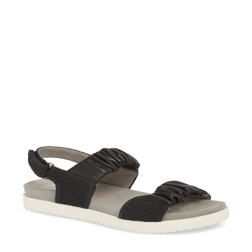

In [8]:
from PIL import Image

image = Image.open('/kaggle/input/fashion-image-caption-using-image-files/images/01d9276f-48ce-47cf-93ed-f86b9fc78dbb.jpeg')

#Inferance on GPU. When used this on GPU will get errors like: "slow_conv2d_cpu" not implemented for 'Half'" , " Input type (float) and bias type (struct c10::Half)"
#inputs = processor(images = image, return_tensors = "pt").to('cuda', torch.float16)

#Inferance on CPU 
inputs = processor(images = image, return_tensors = "pt")
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values = pixel_values, max_length = 10)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]  

print('Caption: '+ generated_caption)
image.resize((252,252))

The `language_model` is not in the `hf_device_map` dictionary and you are running your script in a multi-GPU environment. this may lead to unexpected behavior when using `accelerate`. Please pass a `device_map` that contains `language_model` to remove this warning. Please refer to https://github.com/huggingface/blog/blob/main/accelerate-large-models.md for more details on creating a `device_map` for large models.


Caption: black check high waist jeans


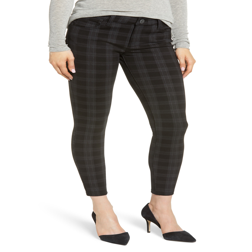

In [9]:
image = Image.open('/kaggle/input/fashion-image-caption-using-image-files/images/01916d6f-fe7d-41f5-b26c-bd4ed071a257.jpeg')

#Inferance on GPU. When used this on GPU will get errors like: "slow_conv2d_cpu" not implemented for 'Half'" , " Input type (float) and bias type (struct c10::Half)"
#inputs = processor(images = image, return_tensors = "pt").to('cuda', torch.float16)

#Inferance on CPU 
inputs = processor(images = image, return_tensors = "pt")
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values = pixel_values, max_length = 10)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]  

print('Caption: '+ generated_caption)
image.resize((252,252))

The `language_model` is not in the `hf_device_map` dictionary and you are running your script in a multi-GPU environment. this may lead to unexpected behavior when using `accelerate`. Please pass a `device_map` that contains `language_model` to remove this warning. Please refer to https://github.com/huggingface/blog/blob/main/accelerate-large-models.md for more details on creating a `device_map` for large models.


Caption: black red wrap front houndstooth pajamas


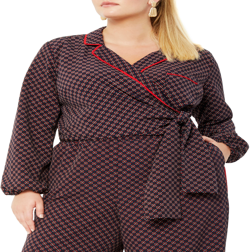

In [10]:
image = Image.open('/kaggle/input/fashion-image-caption-using-image-files/images/02ed0633-f4b6-444a-914c-29085141a61c.jpeg')

#Inferance on GPU. When used this on GPU will get errors like: "slow_conv2d_cpu" not implemented for 'Half'" , " Input type (float) and bias type (struct c10::Half)"
#inputs = processor(images = image, return_tensors = "pt").to('cuda', torch.float16)

#Inferance on CPU 
inputs = processor(images = image, return_tensors = "pt")
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values = pixel_values, max_length = 10)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]  

print('Caption: '+ generated_caption)
image.resize((252,252))

The `language_model` is not in the `hf_device_map` dictionary and you are running your script in a multi-GPU environment. this may lead to unexpected behavior when using `accelerate`. Please pass a `device_map` that contains `language_model` to remove this warning. Please refer to https://github.com/huggingface/blog/blob/main/accelerate-large-models.md for more details on creating a `device_map` for large models.


Caption: dark olive the neck tee


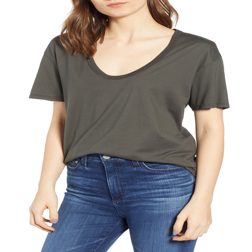

In [11]:
image = Image.open('/kaggle/input/fashion-image-caption-using-image-files/images/042f26d1-741d-4c3e-a085-fe151dee5d40.jpeg')

#Inferance on GPU. When used this on GPU will get errors like: "slow_conv2d_cpu" not implemented for 'Half'" , " Input type (float) and bias type (struct c10::Half)"
#inputs = processor(images = image, return_tensors = "pt").to('cuda', torch.float16)

#Inferance on CPU 
inputs = processor(images = image, return_tensors = "pt")
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values = pixel_values, max_length = 25)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]  

print('Caption: '+ generated_caption)
image.resize((252,252))